In [1]:
from sklearn.datasets import fetch_openml
from sklearn import preprocessing
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
ds = fetch_openml('mnist_784')
x, y = ds.data, ds.target

In [3]:
cutoff = 60000
training_x = x[:cutoff]
training_y = y[:cutoff]
validation_x = x[cutoff:]
validation_y = y[cutoff:]

In [4]:
train_ix = np.logical_or(training_y == '0', training_y == '1')
val_ix = np.logical_or(validation_y == '0', validation_y == '1')

In [5]:
train_x = training_x[train_ix]
train_y = training_y[train_ix]

val_x = validation_x[val_ix]
val_y = validation_y[val_ix]

In [6]:
print(train_x.shape, val_x.shape)

(12665, 784) (2115, 784)


In [7]:
def resize_images(df, old, new):
    df_temp = df
    num_samples = df_temp.shape[0]
    df_temp = df_temp.reshape((num_samples, old, old))
    downsized = np.zeros((num_samples, new, new))
    for ix in range(num_samples):
        downsized[ix] = cv2.resize(df_temp[ix], (new, new))
    downsized = downsized.reshape((num_samples, new**2))
    return downsized

In [8]:
resized_train_x = resize_images(train_x, 28, 14)
resized_val_x = resize_images(val_x, 28, 14)

In [9]:
label_changer = lambda x: 1 if x == '0' else -1
vector_func = np.vectorize(label_changer)
labeled_train_y = vector_func(train_y)
labeled_val_y = vector_func(val_y)

In [10]:
w = np.random.rand(resized_train_x.shape[1])
b = np.random.rand(1)

In [11]:
class linear_t:
    def __init__(self):
        
        self.w = np.random.rand(resized_train_x.shape[1] + 1)
        
        self.hl = None
        self.dw = 0.0
        
    def forward(self, h_l):
        
        bias_row = np.ones((h_l.shape[0], 1))
        appended_x = np.concatenate((h_l, bias_row), axis = 1)
        h_l = appended_x
        
        h_l1 = np.matmul(h_l, np.transpose(self.w))
        self.hl = h_l
        return h_l1
    
    def backward(self, dh_l1):
        dh_l = np.matmul(dh_l1, self.w)
        dw = np.matmul(dh_l1.T, self.hl)
                
        self.dw = dw
        return dh_l
    
    def zero_grad(self):
        self.dw = 0.0 * self.dw

In [24]:
class log_loss_nesterov:
    def __init__(self):
        self.y = 0.0
        self.yhat = 0.0
        self.w = 0.0
        self.lam = 0.0
        
    def forward(self, x, y, yhat, w, lam):
        loss = 0
                
        for i in range(len(y)):
            loss_i = np.log(1 + np.exp(-y[i] * yhat[i]))
            loss += loss_i
        loss /= len(y)
        
        lambda_loss = lam/2 * np.linalg.norm(w, 2)
        loss += lambda_loss
        
        self.y = y
        self.yhat = yhat
        self.w = w
        self.lam = lam
        
        bias_row = np.ones((x.shape[0], 1))
        appended_x = np.concatenate((x, bias_row), axis = 1)
        self.x = appended_x
        
        pred_val = lambda x: 1 if x < 0 else -1
        vector_func = np.vectorize(pred_val)
        pred = vector_func(yhat)
        acc = np.sum(pred == y) / len(pred)
        return 1 - acc, loss
    
    def backward(self, new_w):
        dw = 0.0
        for i in range(len(self.y)):
            e_term = np.exp(-self.y[i] * np.matmul(self.x[i], np.transpose(new_w)))
            dw += self.x[i] *((self.y[i] * e_term) / (1 + e_term))
        dw /= len(y)
        dw += self.lam * np.linalg.norm(new_w, 1)
        return dw
    
    def zero_grad(self):
        return

In [62]:
lr = 1
lam = 1e-3
k = 0.071
L = 0.054
gamma = L / k

In [63]:
l1, l3 = linear_t(), log_loss_nesterov()
last_update = l1.w
net = [l1, l3]

In [64]:
train_error_list, train_loss_list, val_error_list, val_loss_list = [], [], [], []

In [65]:
x, y = preprocessing.scale(resized_train_x), labeled_train_y
x_val, y_val = preprocessing.scale(resized_val_x), labeled_val_y

In [66]:
for t in range(5):
    
    for l in net:
        l.zero_grad()
        
    hl = l1.forward(x)
    ell, error = l3.forward(x, y, hl, l1.w, lam)
    
    print(t, ell, error)
    
    train_loss_list.append(ell)
    train_error_list.append(error)
    
    hl = l1.forward(x_val)
    
    val_loss, val_error = l3.forward(x_val, y_val, hl, l1.w, lam)
    
    val_loss_list.append(val_loss)
    val_error_list.append(val_error)
    
    momentum = gamma * last_update
    dw = l3.backward(l1.w - momentum)
    nesterov_dw = momentum + lr * dw
    last_update = nesterov_dw
    
    l1.w = l1.w - nesterov_dw

0 0.9205684958547178 0.6863888314972214
1 0.8928543229372286 0.29345693549043417
2 0.03963679431504141 13.595156051385823
3 0.04026845637583898 34.34488500839268
4 0.039399921042242436 61.217867042205356


In [67]:
log_train_loss = [np.log(x) for x in train_loss_list]
log_val_loss = [np.log(x) for x in val_loss_list]

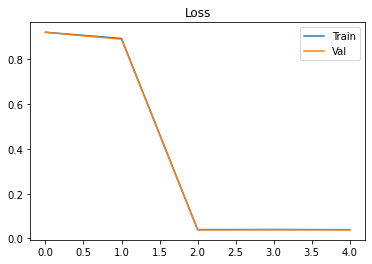

In [68]:
plt.plot(train_loss_list, label='Train')
plt.plot(val_loss_list, label='Val')
plt.legend()
plt.title('Loss')
plt.show()